# 模拟投资策略

## 1. 数据预处理

In [1]:
import pandas as pd
import numpy as np
from keras.models import load_model

# 全局变量定义
model_path = '../models/lstm_model.h5'
cols = [0,1,2,3,4,6,7,9,12,13,14]
feanum=6 # 一共有多少特征
window=7 # 时间窗设置

In [2]:
# 读取测试集数据
df = pd.read_csv("../data/test.csv", usecols=cols)
stocks_code = df["kdcode"].unique()
stock_num = len(stocks_code)

# 根据股票代码划分数据
for i, stock_i in enumerate(stocks_code):
    stock_i_data = df[df['kdcode'].isin([stock_i])]
    exec("stockDf%s = stock_i_data" % i)
    exec("stockDf%s.set_index(['dt'], inplace = True)" % i)
    exec("stockDf%s.index = pd.to_datetime(stockDf%s.index)" % (i, i))

In [3]:
stockDf0

,kdcode,price_mean1,price_mean5,price_mean10,pct_mean3,pct_mean5,close_mean5,adj_close,adj_open,label
dt,,,,,,,,,,
2020-01-02,000001.SZ,0.007344,0.007478,0.007507,0.194480,0.198148,0.120051,0.116052,0.117903,1.0
2020-01-03,000001.SZ,0.007521,0.007545,0.007550,0.208026,0.201087,0.121080,0.118188,0.119959,1.0
2020-01-06,000001.SZ,0.007516,0.007584,0.007582,0.208543,0.195127,0.121717,0.117430,0.120456,0.0
2020-01-07,000001.SZ,0.007502,0.007650,0.007616,0.195698,0.198194,0.122557,0.117981,0.121306,1.0
2020-01-08,000001.SZ,0.007338,0.007677,0.007628,0.166769,0.190307,0.122861,0.114606,0.120385,0.0
...,...,...,...,...,...,...,...,...,...,...
2020-12-25,000001.SZ,0.007945,0.008300,0.008513,0.190352,0.178923,0.133137,0.126231,0.131527,0.0
2020-12-28,000001.SZ,0.008214,0.008337,0.008498,0.214577,0.197138,0.133976,0.131906,0.129796,1.0
2020-12-29,000001.SZ,0.008499,0.008442,0.008535,0.216137,0.211104,0.135848,0.134148,0.135926,1.0


In [4]:
# 读取并处理出各股票的开盘价、收盘价未归一化的数据
# 读取数据
df2 = pd.read_csv("strategyTestData.csv")
stocks_code2 = df2["kdcode"].unique()
stock_num2 = len(stocks_code2)

# 根据股票代码划分数据
for i, stock_i in enumerate(stocks_code2):
    stock_i_data = df2[df2['kdcode'].isin([stock_i])]
    exec("PriceMsgDf%s = stock_i_data" % i)
    exec("PriceMsgDf%s.set_index(['dt'], inplace = True)" % i)
    exec("PriceMsgDf%s.index = pd.to_datetime(stockDf%s.index)" % (i, i))

In [5]:
PriceMsgDf81

,kdcode,adj_close,adj_open
dt,,,
2020-01-02,603833.SH,118.470896,118.795807
2020-01-03,603833.SH,118.328747,118.795807
2020-01-06,603833.SH,115.749761,115.749761
2020-01-07,603833.SH,118.389668,117.272784
2020-01-08,603833.SH,118.186598,117.029100
...,...,...,...
2020-12-25,603833.SH,171.287863,176.289910
2020-12-28,603833.SH,180.231351,170.671565
2020-12-29,603833.SH,179.686715,178.726437


## 2. 模拟投资策略

In [6]:
model = load_model(model_path) # 加载模型

In [7]:
now_money = 1000000 # 初始总钱
position_num = 5 # 最多持有股票的数量
threshold = 0.55 # 表示预测为涨的阈值

# 判断index股票在day日是否可以交易
# param: index 第几只股票
#        day 哪一天
#        pList 所有股票预测出的概率
def canBuyOrSell(stock_index, day, pList):
    # 判断是否停牌
    day = pd.to_datetime(day)
    res = nowData[nowData.index.isin([day])]
    if len(res) == 0:
        return False
    # 判断pList中index股票p是否等于nan
    for [p,ind] in pList:
        if ind == stock_index and np.isnan(p):
            return False
    return True

# 策略
PriorList = [] # 每天最优持有的股票
tot = len(stockDf0.index[:-window + 1]) # 总天数
allPSetList = [] # 每天股票与概率的字典的列表
for (t,st_date) in enumerate(stockDf0.index[:-window + 1]):
    date_period = pd.date_range(start = st_date, periods = window + 1, freq = "B")
    today = date_period[-1]
    pList = [] # 当天所有股票的概率 [[p,index],...[]]
    pDict = dict()
    for stock_index in range(stock_num):
        # 1. 处理为LSTM输入的数据
        exec("inputData = stockDf%s[stockDf%s.index.isin(date_period[:-1])]" % (stock_index, stock_index))
        inputData = inputData.iloc[:,[1,2,3,4,5,6]]
        inputData = inputData.values
        inputData = inputData.reshape((1,inputData.shape[0],feanum))
        # 2. 模型预测结果
        if inputData.shape[1] == 0: # Todo 包含停牌数据预测的处理
            p = np.nan
        else:
            p = model.predict(inputData)[:,0][0]
        pList.append([p,stock_index])
        pDict[stock_index] = p
    pList.sort(reverse = True) # 从高到低排序
    allPSetList.append(pDict)
    
    # 将canBuyOrSell并且p大于threshold的股票加入到PriList中
    tmpList = []
    for i in range(stock_num):
        exec("nowData = stockDf%s.copy()" % i)
        if canBuyOrSell(pList[i][1], today, pList) and pList[i][0] > threshold:
            tmpList.append(pList[i][1])
    tmpList = tmpList[:min(5, len(tmpList))]
    PriorList.append(tmpList)
    print("tot:", tot, t + 1, tmpList)

tot: 237 1 []
tot: 237 2 [74]
tot: 237 3 [45]
tot: 237 4 [0]
tot: 237 5 [43, 45]
tot: 237 6 []
tot: 237 7 [22]
tot: 237 8 [22, 36, 3, 0, 74]
tot: 237 9 []
tot: 237 10 []
tot: 237 11 []
tot: 237 12 []
tot: 237 13 []
tot: 237 14 []
tot: 237 15 []
tot: 237 16 [74, 3, 56, 16, 22]
tot: 237 17 [54, 58, 3, 41, 35]
tot: 237 18 []
tot: 237 19 []
tot: 237 20 []
tot: 237 21 []
tot: 237 22 []
tot: 237 23 [80, 39, 79]
tot: 237 24 [80]
tot: 237 25 []
tot: 237 26 [80, 39]
tot: 237 27 [40]
tot: 237 28 [15, 39, 46, 8]
tot: 237 29 [80, 39, 9, 50, 8]
tot: 237 30 [80, 50, 74, 3, 39]
tot: 237 31 [13, 20, 45, 39, 8]
tot: 237 32 [50, 51, 15]
tot: 237 33 [13, 51, 14, 39, 80]
tot: 237 34 [48, 75, 21, 8]
tot: 237 35 [50, 14, 13, 48, 8]
tot: 237 36 [51, 13, 50, 8, 20]
tot: 237 37 [48, 23, 31]
tot: 237 38 [48, 13, 14]
tot: 237 39 [40, 68, 14, 23, 20]
tot: 237 40 [14, 40, 45, 39, 80]
tot: 237 41 [80, 14, 48, 31, 1]
tot: 237 42 [40, 77, 23, 17, 3]
tot: 237 43 [77, 14, 45, 3, 39]
tot: 237 44 [3, 49, 40, 32, 7]


<ipython-input-7-2b263b9758fe>:43: RuntimeWarning: invalid value encountered in greater
  pList.sort(reverse = True) # 从高到低排序
<ipython-input-7-2b263b9758fe>:43: RuntimeWarning: invalid value encountered in less
  pList.sort(reverse = True) # 从高到低排序


tot: 237 45 [14, 39, 21, 40, 36]
tot: 237 46 [14, 40, 36, 7, 21]
tot: 237 47 [40, 35, 21, 13, 37]
tot: 237 48 [0, 7, 4]
tot: 237 49 [4, 63, 68, 49, 51]
tot: 237 50 [63, 51, 36, 80, 50]
tot: 237 51 [74, 68, 50, 15, 23]
tot: 237 52 [51]
tot: 237 53 [51, 22, 5, 13]
tot: 237 54 [16]
tot: 237 55 []
tot: 237 56 [22]
tot: 237 57 [15]
tot: 237 58 []
tot: 237 59 []
tot: 237 60 [36]
tot: 237 61 [51, 13, 48]
tot: 237 62 [7, 8]
tot: 237 63 []
tot: 237 64 []
tot: 237 65 [23, 7]
tot: 237 66 [7, 3, 39]
tot: 237 67 [7]
tot: 237 68 [23]
tot: 237 69 [39, 77, 8, 15, 50]
tot: 237 70 [75]
tot: 237 71 [39]
tot: 237 72 [39, 38, 56]
tot: 237 73 []
tot: 237 74 []
tot: 237 75 []
tot: 237 76 []
tot: 237 77 []
tot: 237 78 []
tot: 237 79 []
tot: 237 80 [17, 74, 39, 38]
tot: 237 81 []
tot: 237 82 [14, 36]
tot: 237 83 []
tot: 237 84 [39, 31, 18]
tot: 237 85 [51, 14, 31, 23, 36]
tot: 237 86 [80, 39, 13, 0, 56]
tot: 237 87 [48, 51, 14]
tot: 237 88 []
tot: 237 89 [19, 48, 50, 14, 80]
tot: 237 90 [19, 39, 31, 48, 38]
to

In [8]:
# 回测
init_money = 1000000 # 初始资金
now_money = 1000000
nowStock = [] # 当前持有的股票
buyOrSellNum = 200 # 买或卖buyOrSellNum股
moneyList = []
openPriceCache = dict()
for (t,st_date) in enumerate(stockDf0.index[:-window]):
    date_period = pd.date_range(start = st_date, periods = window + 1, freq = "B")
    today = date_period[-1]
    pNowStock = [] # 当前持有股票的涨跌概率
    pSet = allPSetList[t] # 当天所有股票涨跌概率
    # 求当前持有股票的涨跌概率
    for stock in nowStock:
        p = pSet[stock]
        pNowStock.append([p, stock])
    # 卖掉所有持有的可以操作的股票
    print(t, "卖前", now_money, nowStock)
    for [p, stock_idx] in pNowStock:
        if canBuyOrSell(stock_idx, today, pNowStock):
            exec("res = PriceMsgDf%s[PriceMsgDf%s.index.isin([today])]" % (stock_idx, stock_idx))
            if len(res) == 0:
                continue
            open_price = res['adj_open'].values[0]
            nowStock.remove(stock_idx)
            now_money += open_price * buyOrSellNum
            openPriceCache[stock_idx] = open_price
    print(t, "卖后", now_money, nowStock)
    
    # 尽可能多的买下所有当天最优的持有股票
    DestList = PriorList[t]
    for stock_idx in DestList:
        exec("res = PriceMsgDf%s[PriceMsgDf%s.index.isin([today])]" % (stock_idx, stock_idx))
        if len(res) == 0:
            continue                                  # 这里不能continue
        open_price = res['adj_open'].values[0]
        if now_money > (open_price * buyOrSellNum):
            now_money -= open_price * buyOrSellNum
            nowStock.append(stock_idx)
            openPriceCache[stock_idx] = open_price
    print(t, "买后", now_money, nowStock)
    
    # 计算当前所有资金（持有资金 股票资金）
    tot_money = now_money
    for stock_idx in nowStock:
        exec("res = PriceMsgDf%s[PriceMsgDf%s.index.isin([today])]" % (stock_idx, stock_idx))
        if len(res) == 0:
            open_price = openPriceCache[stock_idx]
        else:
            open_price = res['adj_open'].values[0]
        tot_money += open_price * buyOrSellNum
    moneyList.append(tot_money)
    
print("maximum in total money", max(moneyList))
print("final total money:", moneyList[-1])

0 卖前 1000000 []
0 卖后 1000000 []
0 买后 1000000 []
1 卖前 1000000 []
1 卖后 1000000 []
1 买后 998195.58942064 [74]
2 卖前 998195.58942064 [74]
2 卖后 999968.04177448 []
2 买后 892629.54925278 [45]
3 卖前 892629.54925278 [45]
3 卖后 1000747.4383219801 []
3 买后 654727.2841096601 [0]
4 卖前 654727.2841096601 [0]
4 卖后 997815.06413374 []
4 买后 873522.0155332 [43, 45]
5 卖前 873522.0155332 [43, 45]
5 卖后 998985.1102187401 []
5 买后 998985.1102187401 []
6 卖前 998985.1102187401 []
6 卖后 998985.1102187401 []
6 买后 952019.9044935 [22]
7 卖前 952019.9044935 [22]
7 卖后 998918.2320333 []
7 买后 17922.037456960035 [22, 36, 3, 0, 74]
8 卖前 17922.037456960035 [22, 36, 3, 0, 74]
8 卖后 1007583.35664154 []
8 买后 1007583.35664154 []
9 卖前 1007583.35664154 []
9 卖后 1007583.35664154 []
9 买后 1007583.35664154 []
10 卖前 1007583.35664154 []
10 卖后 1007583.35664154 []
10 买后 1007583.35664154 []
11 卖前 1007583.35664154 []
11 卖后 1007583.35664154 []
11 买后 1007583.35664154 []
12 卖前 1007583.35664154 []
12 卖后 1007583.35664154 []
12 买后 1007583.35664154 []
13 卖前 1

102 卖后 1130403.0305295195 []
102 买后 1130403.0305295195 []
103 卖前 1130403.0305295195 []
103 卖后 1130403.0305295195 []
103 买后 1075349.7317554397 [22]
104 卖前 1075349.7317554397 [22]
104 卖后 1130796.7009827998 []
104 买后 276357.7005219597 [0, 3]
105 卖前 276357.7005219597 [0, 3]
105 卖后 1144612.9626620798 []
105 买后 1111664.1930956799 [9]
106 卖前 1111664.1930956799 [9]
106 卖后 1142648.1277796798 []
106 买后 526530.7961273798 [9, 3]
107 卖前 526530.7961273798 [9, 3]
107 卖后 1161841.9947957797 []
107 买后 1161841.9947957797 []
108 卖前 1161841.9947957797 []
108 卖后 1161841.9947957797 []
108 买后 1161841.9947957797 []
109 卖前 1161841.9947957797 []
109 卖后 1161841.9947957797 []
109 买后 1161841.9947957797 []
110 卖前 1161841.9947957797 []
110 卖后 1161841.9947957797 []
110 买后 1130895.8453979797 [9]
111 卖前 1130895.8453979797 [9]
111 卖后 1162068.7065129797 []
111 买后 1162068.7065129797 []
112 卖前 1162068.7065129797 []
112 卖后 1162068.7065129797 []
112 买后 1162068.7065129797 []
113 卖前 1162068.7065129797 []
113 卖后 1162068.70651297

186 买后 17195.257407739526 [11, 39]
187 卖前 17195.257407739526 [11, 39]
187 卖后 1178818.7237300393 []
187 买后 764270.5807720193 [38, 31, 18, 15]
188 卖前 764270.5807720193 [38, 31, 18, 15]
188 卖后 1188815.0007873594 []
188 买后 179750.6372292394 [71, 8, 20, 46, 11]
189 卖前 179750.6372292394 [71, 8, 20, 46, 11]
189 卖后 1211535.3532698194 []
189 买后 28759.997332979387 [51, 8, 39, 50]
190 卖前 28759.997332979387 [51, 8, 39, 50]
190 卖后 1223359.3457612596 []
190 买后 17964.46904541945 [38, 39, 50]
191 卖前 17964.46904541945 [38, 39, 50]
191 卖后 1243251.073399099 []
191 买后 779230.191534779 [20, 1, 71, 45]
192 卖前 779230.191534779 [20, 1, 71, 45]
192 卖后 1234285.420493519 []
192 买后 277260.71774171904 [56, 71, 1, 31]
193 卖前 277260.71774171904 [56, 71, 1, 31]
193 卖后 1217825.835174159 []
193 买后 542922.927516719 [56, 71, 66, 15, 41]
194 卖前 542922.927516719 [56, 71, 66, 15, 41]
194 卖后 1237111.193304499 []
194 买后 241034.69424667896 [71, 7, 39]
195 卖前 241034.69424667896 [71, 7, 39]
195 卖后 1246397.0913465389 []
195 买后 59

Text(0, 0.5, 'Profit Ratio(%)')

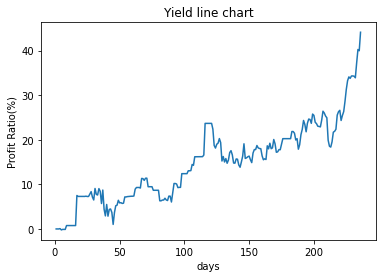

In [9]:
# 收益率变化曲线
import matplotlib.pyplot as plt

days = range(1, len(stockDf0.index[:-window]) + 1)
moneyList = np.array(moneyList)
profit_ratio = (moneyList - init_money) / init_money
profit_ratio *= 100
profit_ratio

plt.plot(days, profit_ratio, label = 'Profit Ratio')
plt.title('Yield line chart')
plt.xlabel('days')
plt.ylabel('Profit Ratio(%)')

## 单元测试

In [10]:
# # 单元测试1 测试canBuyOrSell函数

# ppList = [[np.nan, 22], [0.59513134, 56], [0.5911934, 3], [0.56857383, 74], [0.5606358, 17], [0.5588775, 63], [0.558492, 19], [0.557015, 0], [0.5553074, 9], [0.55123156, 12], [0.54988277, 16], [0.5480421, 2], [0.54735094, 70], [0.5437275, 49], [0.54151696, 47], [0.54024804, 45], [0.54002637, 39], [0.53971076, 30], [0.5383594, 31], [0.5382879, 36], [0.5356826, 21], [0.5341861, 81], [0.53320944, 40], [0.53318095, 37], [0.53308034, 42], [0.52598095, 55], [0.52560496, 10], [0.52555954, 69], [0.5246366, 33], [0.5243099, 52], [0.5231771, 41], [0.5219507, 66], [0.5217557, 35], [0.5212795, 38], [0.5198239, 25], [0.5172703, 53], [0.514381, 32], [0.51411617, 61], [0.51250756, 6], [0.5116291, 24], [0.50913256, 11], [0.5075126, 54], [0.5067256, 71], [0.50646174, 48], [0.5046982, 7], [0.501216, 34], [0.5010961, 68], [0.5009133, 57], [0.49952868, 60], [0.49559373, 64], [0.4954788, 65], [0.49384275, 72], [0.4913066, 4], [0.4911093, 58], [0.48906785, 18], [0.48707077, 23], [0.48694274, 44], [0.48640633, 8], [0.48550946, 26], [0.4818525, 75], [0.48141715, 20], [0.47996283, 14], [0.47836575, 5], [0.47822124, 1], [0.47653505, 28], [0.4753328, 46], [0.47372493, 43], [0.47319898, 15], [0.47246543, 62], [0.4718764, 76], [0.47153977, 73], [0.47098902, 78], [0.4689083, 80], [0.46864882, 51], [0.46791682, 59], [0.46549064, 67], [0.4626018, 27], [0.46060893, 13], [0.46038687, 79], [0.4581696, 50], [0.4568532, 29], [0.45347258, 77]]

# # 判断index股票在day日是否可以交易
# # param: index 第几只股票
# #        day 哪一天
# #        pList 所有股票预测出的概率
# def canBuyOrSell(stock_index, day, pList):
#     # 判断是否停牌
#     day = pd.to_datetime(day)
#     res = nowData[nowData.index.isin([day])]
#     if len(res) == 0:
#         return False
#     # 判断pList中index股票p是否等于nan
#     for [p,ind] in pList:
#         if ind == stock_index and np.isnan(p):
#             return False
#     return True

# input_day = pd.to_datetime('2020-01-02')
# exec("nowData = stockDf%s.copy()" % 21)
# canBuyOrSell(21, input_day, ppList)